# NeRF Activation Sparsity
Run the `accelerating_nerfs/nerf_activation_sparsity.py` script to compute the sparsities. You need to use the NeRF environment for that.

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

In [2]:
sparsity_results_path = "../accelerating_nerfs/2023-05-03_00-21-28_sparsity.json"
with open(sparsity_results_path, "r") as f:
    sparsity_results = json.load(f)
skip_keys = ["overall"]

print(f"Loaded sparsity results for {sparsity_results.keys()}")

Loaded sparsity results for dict_keys(['chair', 'drums', 'ficus', 'hotdog', 'lego', 'materials', 'mic', 'ship', 'overall'])


In [3]:
processed_results = defaultdict(dict)
sparsity_key = 'avg_sparsity'
sparsity_std_key = 'std_sparsity'

for scene, results in sparsity_results.items():
    if scene in skip_keys:
        continue
        
    for layer_name, layer_result in results.items():
        _, num = layer_result["fc_label"].split("_")
        label = f"fc_{int(num) + 1}"
        processed_results[scene][label] = {
            "sparsity": layer_result[sparsity_key],
            "std": layer_result[sparsity_std_key] if sparsity_std_key else None
        }

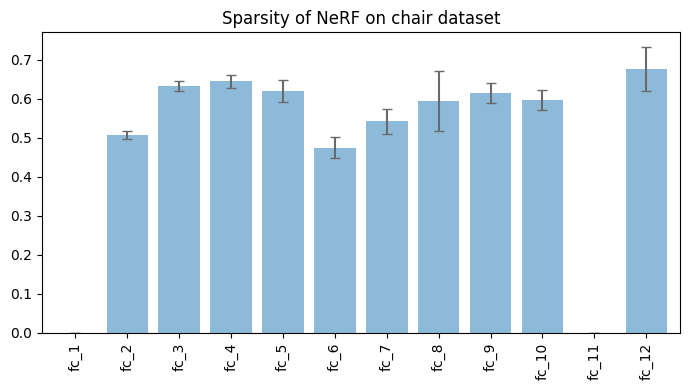

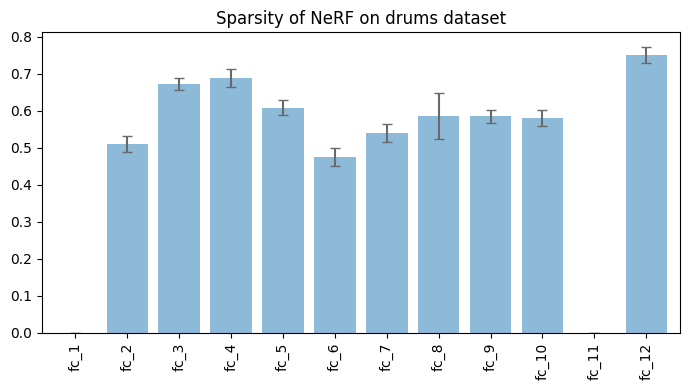

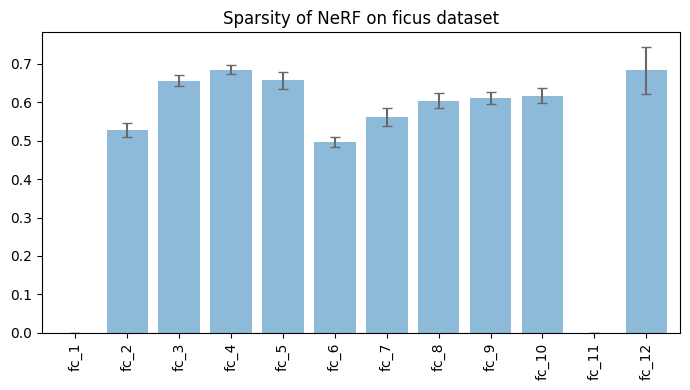

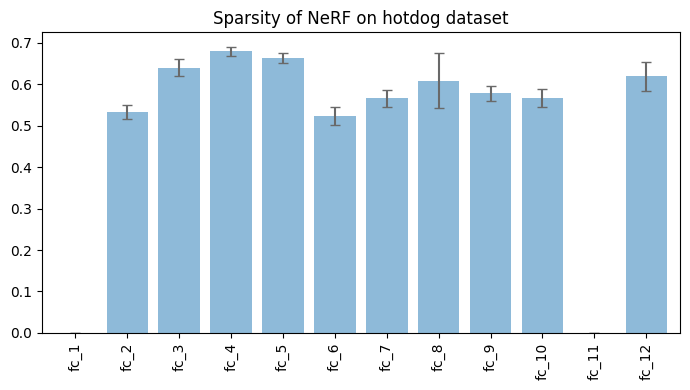

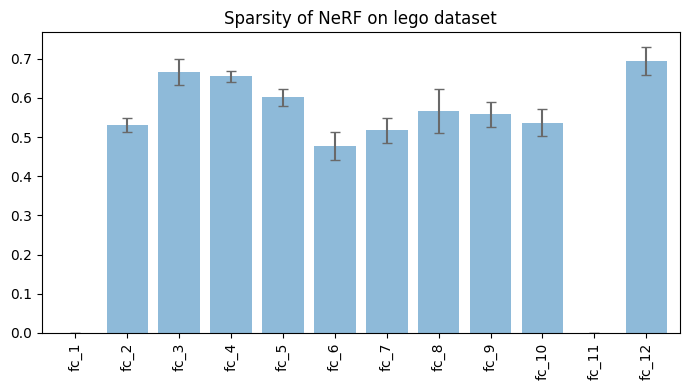

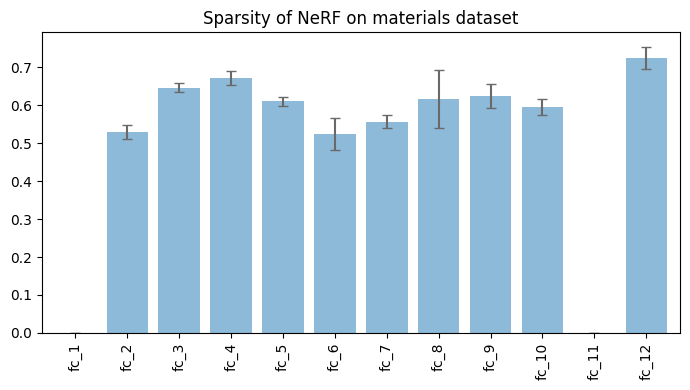

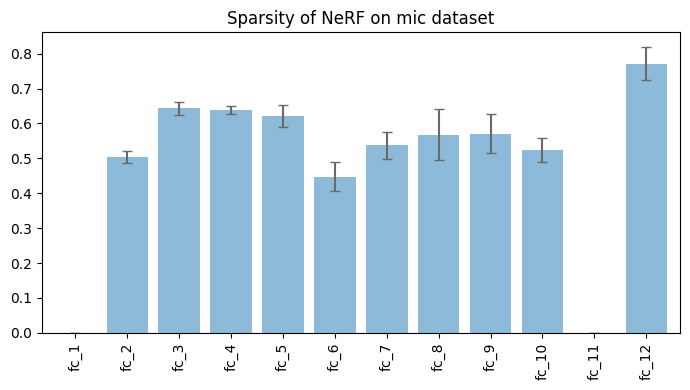

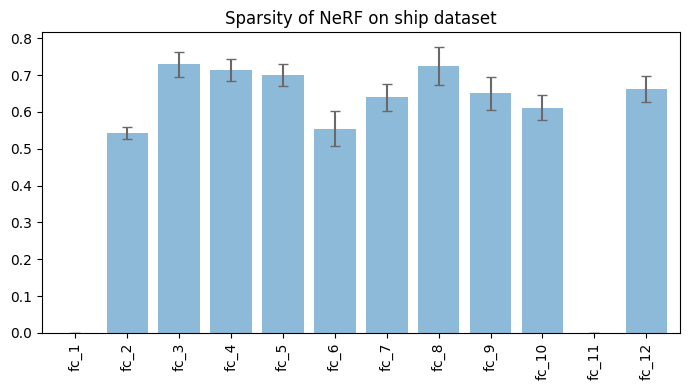

In [4]:
dfs = [pd.DataFrame.from_dict(results, orient="index") for results in processed_results.values()]
os.makedirs("figures", exist_ok=True)

for label, df in zip(processed_results.keys(), dfs):
    err = df['std']
    ax = df.plot.bar(
        y="sparsity", yerr=err, width=0.8, figsize=(7, 4), 
        align='center', alpha=0.5, ecolor='dimgray', capsize=3.5
    )
    ax.get_legend().remove()
    ax.set_title(f"Sparsity of NeRF on {label} dataset")
    ax.figure.tight_layout()
    ax.figure.savefig(f"figures/{label}_sparsity.pdf")